# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

health_data = pd.read_csv("data/health_nutrition.csv")
economy_indicators = pd.read_csv("data/global_economy_indicators.csv")

# Constraints of Interest

In [2]:
years = [str(year) for year in range(1995, 2011)]

regions = {
    'Balkans': ['Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Greece',
                'Montenegro', 'North Macedonia', 'Romania', 'Serbia', 'Slovenia', 'Kosovo'],
    'Baltics': ['Estonia', 'Latvia', 'Lithuania']
}
hiv_indicator_name = 'Adults (ages 15+) and children (0-14 years) living with HIV'

# Filter health data for relevant years (1995-2010)
health_data_filtered = health_data[[
    'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'] + years]

# Main

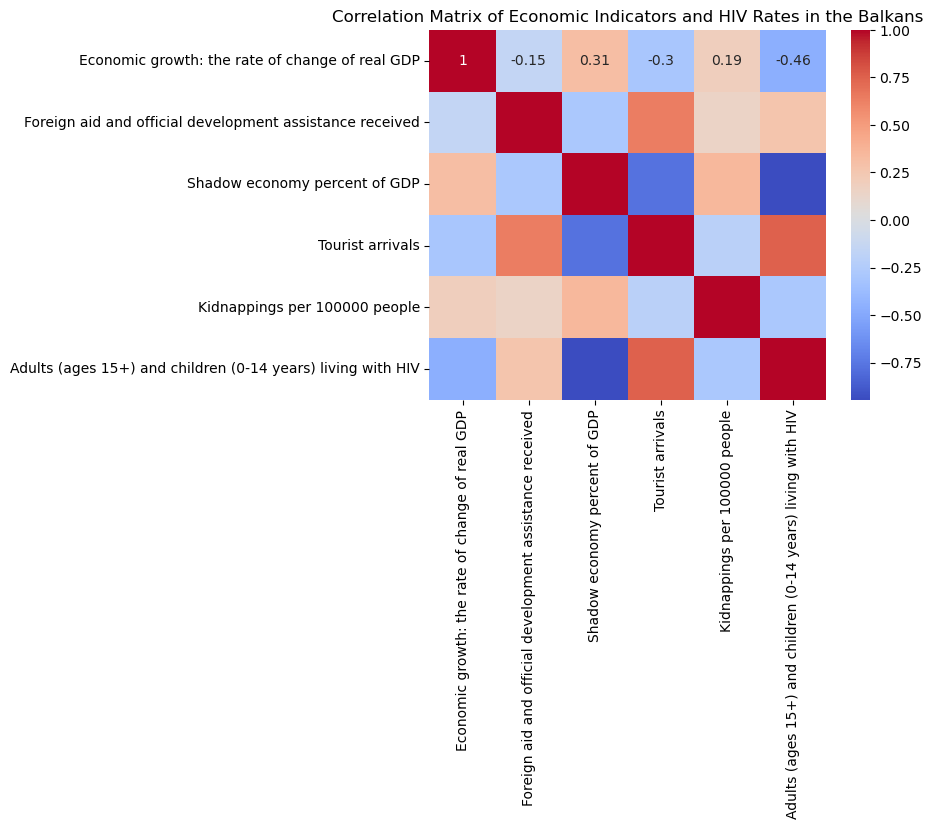

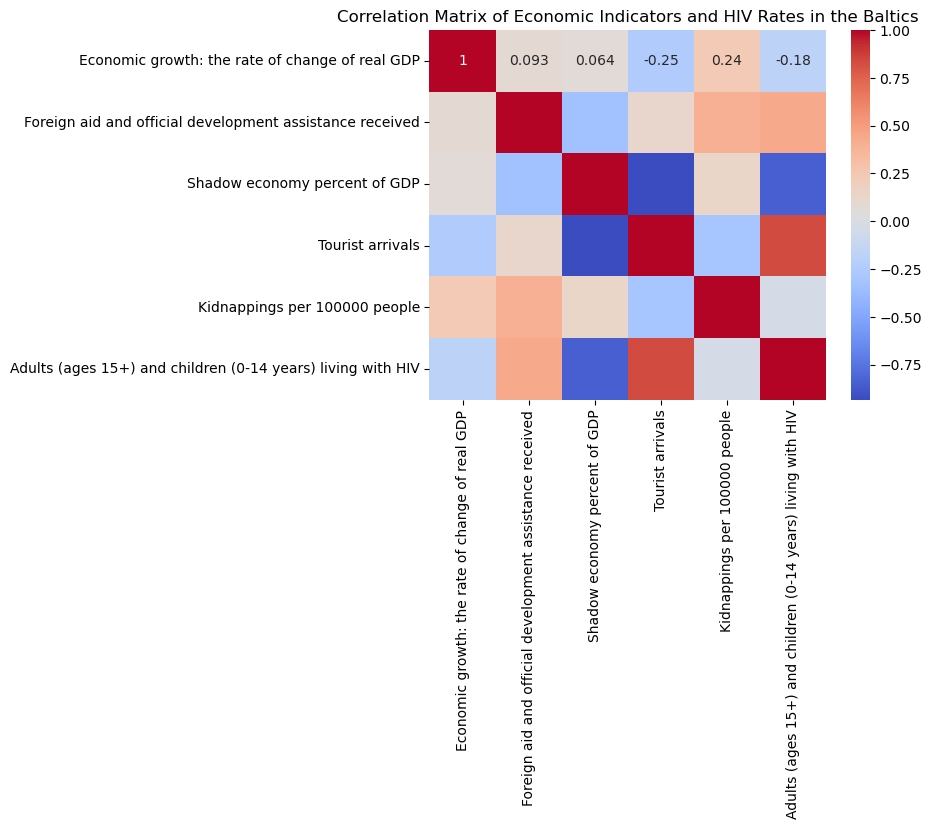

In [23]:
# Reshape health data to long format manually

"""
Starting off, we are going to reshape the health data from wide format (years as columns) 
to long format (years as rows). We want to do this because it makes it easier to analyze 
and plot the data over time.

1. Create an empty DataFrame to store the reshaped data.
2. Loop through each year and create a temporary DataFrame with country and indicator info.
3. Add 'Year' and 'Value' columns to the temporary DataFrame.
4. Concatenate the temporary DataFrame to the main DataFrame.
"""

health_data_long = pd.DataFrame()
for year in years:
    temp_df = health_data_filtered[['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']].copy()
    temp_df['Year'] = int(year)
    temp_df['Value'] = health_data_filtered[year]
    health_data_long = pd.concat([health_data_long, temp_df], ignore_index=True)

# Filter economy indicators for relevant years (1995-2010)

"""
We filter the economy indicators to only include data from 1995 to 2010.
"""

economy_indicators_filtered = economy_indicators[(economy_indicators['Year'] >= 1995) & (economy_indicators['Year'] <= 2010)]

# Calculate mean values for economy indicators

"""
Next, we calculate the mean values for economic indicators for each region over time.
We do this to handle missing values and provide a complete dataset for further analysis.

1. Initialize a dictionary to store mean values for each region.
2. Loop through each region and its countries.
3. Filter the economy data for the current region's countries.
4. Identify numeric columns by excluding the 'Year' column manually.
5. Group the data by 'Year' and calculate the mean for each numeric column.
6. Store the mean values in the dictionary for the current region.
"""

regional_mean_values = {region: {} for region in regions}
for region, countries in regions.items():
    regional_data = economy_indicators_filtered[economy_indicators_filtered['Country'].isin(countries)]
    """
    We want to calculate the mean values of the economic indicators for each year. 
    To do this, we need to identify which columns contain numeric data, 
    excluding the 'Year' column, becauuuuse 'Year' is not an economic indicator but a temporal reference.
    """
    numeric_columns = [col for col in regional_data.columns if col != 'Year' and regional_data[col].dtype in [np.int64, np.float64]]
    mean_values = regional_data.groupby('Year')[numeric_columns].mean()
    regional_mean_values[region] = mean_values

# Calculate mean values for HIV data

"""
We calculate the mean values for HIV data for each region over time.
We do this to handle missing values and provide a complete dataset for further analysis.

1. Initialize a dictionary to store mean values for each region.
2. Loop through each region and its countries.
3. Filter the health data for the current region's countries and the specific HIV indicator.
4. Drop columns that are not needed for mean calculation.
5. Group the data by 'Year' and calculate the mean value.
6. Store the mean values in the dictionary for the current region.
"""

mapToMeanValues = {}
for region, countries in regions.items():
    regional_data = health_data_long[(health_data_long['Country Name'].isin(countries)) & (health_data_long['Indicator Name'] == hiv_indicator_name)]
    regional_data = regional_data.drop(
        columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    mean_values = regional_data.groupby('Year')['Value'].mean()
    mapToMeanValues[region] = mean_values

# Combine the mean values for economic indicators and HIV data into a single DataFrame for correlation analysis

"""
We combine the mean values for economic indicators and HIV data into a single DataFrame for correlation analysis.

1. Initialize a list to store combined data for each region.
2. Loop through each region.
3. Get the mean values for economic indicators and HIV data for the region.
4. Concatenate the mean values into a single DataFrame.
5. Add a 'Region' column to the combined DataFrame.
6. Append the combined DataFrame to the list.
"""

combined_data = []
for region in regions:
    hiv_values = mapToMeanValues[region].rename(
        'Adults (ages 15+) and children (0-14 years) living with HIV')
    econ_values = regional_mean_values[region]
    combined = pd.concat([econ_values, hiv_values], axis=1)
    combined['Region'] = region
    combined_data.append(combined)

# Concatenate all regional data

"""
We concatenate the combined data for all regions into a single DataFrame.
"""

combined_data = pd.concat(combined_data)

# Separate the data by region

"""
We separate the data into two DataFrames, one for the Balkans and one for the Baltics.
"""

balkans_data = combined_data[combined_data['Region'] == 'Balkans'].drop(columns=['Region'])
baltics_data = combined_data[combined_data['Region'] == 'Baltics'].drop(columns=['Region'])

# Fill missing values with the mean

"""
We fill any missing values in the data with the mean of the respective columns to ensure completeness.
"""

balkans_data = balkans_data.apply(lambda x: x.fillna(x.mean()), axis=0)
baltics_data = baltics_data.apply(lambda x: x.fillna(x.mean()), axis=0)

# Compute the correlation matrix for the Balkans

"""
We compute the correlation matrix for the Balkans to analyze the relationships between economic indicators and HIV rates.
"""

correlation_matrix_balkans = balkans_data.corr()

# Compute the correlation matrix for the Baltics

"""
We compute the correlation matrix for the Baltics to analyze the relationships between economic indicators and HIV rates.
"""

correlation_matrix_baltics = baltics_data.corr()

# Plot the correlation matrix for the Balkans using a heatmap

"""
We plot the correlation matrix for the Balkans using a heatmap for visual analysis.
"""

plt.subplot()
sns.heatmap(correlation_matrix_balkans, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Economic Indicators and HIV Rates in the Balkans')
plt.show()

# Plot the correlation matrix for the Baltics using a heatmap

"""
We plot the correlation matrix for the Baltics using a heatmap for visual analysis.
"""

plt.subplot()
sns.heatmap(correlation_matrix_baltics, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Economic Indicators and HIV Rates in the Baltics')
plt.show()

# Balkan Data Outputs

In [ ]:
# Compute the correlation matrix for the Balkans before filling missing values
correlation_matrix_balkans_before = combined_data[combined_data['Region'] == 'Balkans'].drop(columns=['Region']).corr()

# Display summary statistics for the correlation matrix before filling missing values
print("Summary statistics for the correlation matrix before filling missing values (Balkans):")
print(correlation_matrix_balkans_before.describe())

# Compute the correlation matrix for the Balkans after filling missing values
correlation_matrix_balkans_after = balkans_data.corr()

# Display summary statistics for the correlation matrix after filling missing values
print("\nSummary statistics for the correlation matrix after filling missing values (Balkans):")
print(correlation_matrix_balkans_after.describe())

# Baltic Data Outputs

In [ ]:
# Compute the correlation matrix for the Balkans before filling missing values
correlation_matrix_balkans_before = combined_data[combined_data['Region'] == 'Balkans'].drop(
    columns=['Region']).corr()

# Display summary statistics for the correlation matrix before filling missing values (Balkans)
print("Summary statistics for the correlation matrix before filling missing values (Balkans):")
print(correlation_matrix_balkans_before.describe())

# Compute the correlation matrix for the Balkans after filling missing values
correlation_matrix_balkans_after = balkans_data.corr()

# Display summary statistics for the correlation matrix after filling missing values (Balkans)
print("\nSummary statistics for the correlation matrix after filling missing values (Balkans):")
print(correlation_matrix_balkans_after.describe())

# Compute the correlation matrix for the Baltics before filling missing values
correlation_matrix_baltics_before = combined_data[combined_data['Region'] == 'Baltics'].drop(
    columns=['Region']).corr()

# Display summary statistics for the correlation matrix before filling missing values (Baltics)
print("\nSummary statistics for the correlation matrix before filling missing values (Baltics):")
print(correlation_matrix_baltics_before.describe())

# Compute the correlation matrix for the Baltics after filling missing values
correlation_matrix_baltics_after = baltics_data.corr()

# Display summary statistics for the correlation matrix after filling missing values (Baltics)
print("\nSummary statistics for the correlation matrix after filling missing values (Baltics):")
print(correlation_matrix_baltics_after.describe())